# CNN Assignment for Classification problem

In this assignment, a CNN model is created to classify the image of animals from 10 classes. The classes used in the dateset used here are as follows;

1. Cat
2. Cow
3. Dog
4. Elephant
5. Goat
6. Leopard
7. Lion
8. Pig
9. Tiger
10. Zebra

_(Note: In this assignment, pytorch with gpu enabled is used.)_

In [ ]:
# Importing Necessary Libraries
import os
import pickle
import glob

import cv2
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

print(torch.__version__)

: 

In [ ]:
# Checking the availability of accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

: 

## Loading the dataset

The dataset used are in image format. To read the image, its path with corresponding class is stored in csv file, so that when needed the image can be read from that particular path along with its corresponding class.

In [3]:
# Defining the path to the dataset
dataset_folder: str = "./dataset"

# Initializing empty lists to store filename and corresponding labels
filenames: list = []
labels: list = []

# Using glob to recursively iterate throught the images
# And extract the filenames and its corresponding class
# The folder name which consists the image is the corresponding class of that image
for image_file in glob.glob(os.path.join(dataset_folder, "*", "*.jpg")):
        # Extract label from folder name
    label: str = os.path.basename(os.path.dirname(image_file))
    # Add filename to the list
    filenames.append(os.path.basename(image_file))
    # Add corresponding label to the list (category name)
    labels.append(label)

# Creating the dataframe to store the filename and its correspondin label
df: pd.DataFrame = pd.DataFrame({"filename": filenames, "label": labels})

# Displaying the dataset
display(df)

,filename,label
0,00357563a7.jpg,cat
1,029c926ce9.jpg,cat
2,057e6db146.jpg,cat
3,087d293433.jpg,cat
4,094ac674a9.jpg,cat
...,...,...
595,8bc28d0165.jpg,zebra
596,94cf6638fd.jpg,zebra
597,96e65ae7f7.jpg,zebra
598,9c23e26c9d.jpg,zebra


### Encoding the string label to numerical label

To train the model, numerical value must be provided. So, the label must be converted into a numerical value.

For that, we can use LabelEncoder from sklearn.preprocessing library.
```python
    from sklearn.preprocessing import LabelEncoder 

    # Encode labels into numbers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df["label"])
```

Sometimes the LabelEncoder can be bit complex. So, instead of using it we can manually assign numerical value to the class.

lets replace the class with numerical values as follows;
<pre>
    Class            Numerical Value
  -----------------------------------  
    Cat         --->        0
    Cow         --->        1
    Dog         --->        2
    Elephant    --->        3
    Goat        --->        4
    Leopard     --->        5
    Lion        --->        6
    Pig         --->        7
    Tiger       --->        8
    Zebra       --->        9
</pre>

For this, replace function can be used to replace the string label to encode into numberical value.
For example;

```python
    # Replace function in dataframe
    df.replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})
```

In [4]:
# from sklearn.preprocessing import LabelEncoder

# # Encode labels into numbers
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(df["label"])

# df["target"] = encoded_labels

# Label encoder
label_encode_mapper: dict = {
    "cat": 0,
    "cow": 1,
    "dog": 2,
    "elephant": 3,
    "goat": 4,
    "leopard": 5,
    "lion": 6,
    "pig": 7,
    "tiger": 8,
    "zebra": 9
}

inverse_label_encode_mapper: dict = {v: k for k, v in label_encode_mapper.items()}

# Storing the label encoder to different column
# Coping the label to another column called target to replace the string to integer
df["target"] = df["label"]
df["target"].replace(label_encode_mapper, inplace=True)

# Displaying the dataframe
display(df)

,filename,label,target
0,00357563a7.jpg,cat,0
1,029c926ce9.jpg,cat,0
2,057e6db146.jpg,cat,0
3,087d293433.jpg,cat,0
4,094ac674a9.jpg,cat,0
...,...,...,...
595,8bc28d0165.jpg,zebra,9
596,94cf6638fd.jpg,zebra,9
597,96e65ae7f7.jpg,zebra,9
598,9c23e26c9d.jpg,zebra,9


In [5]:
# Storing the dataframe in CSV file
df.to_csv("dataset.csv", index=False)

### Creating a custom Dataset, and DataLoader to load dataset  

Managing the dataset, and loading the dataset can be bit messy. Pytorch provide a functionality of managing the dataset. 

For more info: Link to [tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for pytorch Datasets & DataLoaders

In [6]:
from typing import Tuple

# Creating Custom Dataset
class AnimalDataset(Dataset):
    """
    This class inherit from pytorch Dataset, to create a custom dataset.
    """

    def __init__(self, dataframe, root_dir, is_train, transform=None):
        # Dataframe consisting the metadata of the dataset
        self.dataframe = dataframe
        
        # Root directory consisting the dataset
        self.root_dir = root_dir

        # Transformation if specified
        self.transform = transform

        # Whether the data fetched is for train set or not
        self.is_train = is_train


    def __len__(self) -> int:
        """
        Return the length of data that is fetched.
        """
        return len(self.dataframe)
    
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        """
        Getter function to fetch the image and its correspoding label
        """
        # If the index provided is tensor, converting it into list
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Preparing the full path to the image
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1], 
                                self.dataframe.iloc[idx, 0])
        
        # Reading the image using opencv
        image = cv2.imread(img_name)

        # Converting the image to PIL image
        image = Image.fromarray(image)

        # If the image fetched is for training, returning the label in tensor format
        if self.is_train:
            label = torch.tensor(int(self.dataframe.iloc[idx, 2]))

        else:
            label = torch.tensor(1)

        # Transforming the image to the specified transformation
        if self.transform:
            image = self.transform(image)

        # Returning the tuple of image and its corresponding label
        return image, label

In [7]:
# Desired size of image to be resized
desired_size = (150, 150)

# Configuring the transformation that should be done on image before training
transform = transforms.Compose([
        # Resize the image 
        transforms.Resize(desired_size),  
        # To convert to tensor with compatible data type i.e., float32
        transforms.ToTensor(),  
        # To normalize image: first one is for mean, and second for standard deviation
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  

In [8]:
# Splitting the dataset into train set and test set
from sklearn.model_selection import train_test_split

# Splitting the dataset into 80/20 train/test set
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df["target"])

print(f"Number of train dataset: {len(train_set)}")
print(f"Number of test dataset: {len(test_set)}")

Number of train dataset: 480
Number of test dataset: 120


In [9]:
# Creating a train and test set fromt the custom made dataset
trainset = AnimalDataset(train_set, root_dir="./dataset", is_train=True, transform=transform)
testset = AnimalDataset(test_set, root_dir="./dataset", is_train=True, transform=transform)

In [10]:
# DataLoader for fetching the image and label
batch_size = 32

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

In [11]:
# Checking the shape of the data fetched from DataLoader
train_features, train_labels = next(iter(train_loader))

# First index gives the batch size,
# Second index gives the channel size, 
# And remaining fives height by width
print(f"Feature batch shape: {train_features.size()}")

# Corresponding target label
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 150, 150])
Labels batch shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'lion')

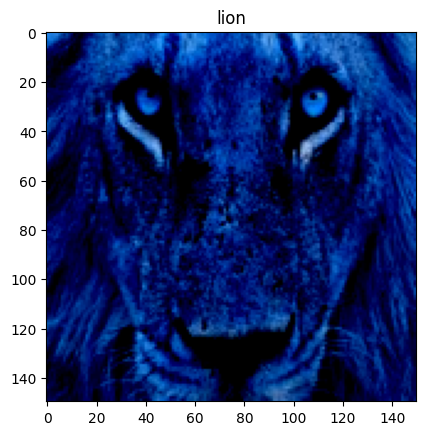

In [12]:
# Checking how the image look like after transformation
import matplotlib.pyplot as plt
from random import randrange

# Random number from 0 to 32
rand_num: int = randrange(0, 32)

# Fetching the image and corresponding label 
image, label = train_features[rand_num], train_labels[rand_num]


# Plotting the figure
plt.figure()
plt.imshow(image.permute(1, 2, 0))
plt.title(inverse_label_encode_mapper[label.item()])

# Training the CNN model


### Confifuring necessary class and functions for creating CNN

In [13]:
# class Conv2D(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int=1, padding: str='same'):
#         """
#         This function initializes the parameters for a conv2D layer

#         Parameters
#         ------------
#             in_channels : int
#             Number of channels in the input image

#             out_channels : int
#             Number of channels produced by the convolution

#             kernel_size : int or tuple
#             Size of the convolving kernel 

#             stride : int or tuple
#             Stride of the convolution. Default: 1

#             padding: int, tuple or str
#             Padding added to all four sides of the input. Default: 'same'
#         """
#         super(Conv2D, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
#         self.stride = stride
#         self.padding = padding

#         # Except for randoming initializing the weights different weight initializer can be used
#         self.weight = nn.Parameter(
#             torch.nn.init.xavier_uniform_(
#                 torch.empty(
#                     (self.out_channels, self.in_channels, *self.kernel_size),
#                     requires_grad=True
#                 )
#             )
#         )
#         self.bias = nn.Parameter(
#             torch.zeros((self.out_channels,), requires_grad=True)
#         )

#     def forward(self, x: torch.tensor):
#         """
#         This function performs convolution operation on the input

#         Parameters
#         ------------
#             x : tensor, float32
#             Input image to the convolution layer

#         Returns
#         ------------
#             x : tensor, float32
#             feature map output from the last layer
#         """

#         # Every convolution layer followed by relu activation function
#         return F.relu(F.conv2d(input=x, weight=self.weight, bias=self.bias, stride=self.stride, padding=self.padding))

In [14]:
class MaxPool(nn.Module):
    def __init__(self, kernel_size: int, stride: int=None, padding: int=0):
        """
        This function initializes the parameters for a maxpool layer

        Parameters
        ------------
            kernel_size : int
            window height and width for the maxpooling window

            stride : int
            the stride of the window. Default value is kernel_size

            padding: int
            implicit zero padding to be added on both sides
        """
        super(MaxPool, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding


    def forward(self, x: torch.tensor): 
        """
        This function performs max-pool operation on the input

        Parameters
        ------------
            x : tensor, float32
            Input image to the convolution layer

        Returns
        ------------
            x : tensor, float32
            max-pooled output from the last layer
        """
        # Returning the max pool operation
        return F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)

In [15]:
class Dense(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        This function initializes the parameters for a dense layer
        Parameters
        ------------- 
            in_features : int
            shape of the input to the dense layer

            out_features : int
            number of units in the dense layer
        """
        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )

    def forward(self, x: torch.tensor):
        """
        This function performs dense operation on the input
        Parameters
        ------------
            x : tensor, float32
            Input flattened image to the convolution layer

        Returns
        ------------
            x : tensor, float32
            linear operation output from the last layer
        """
        # Returning the matrix multiplication
        return torch.mm(x, self.weight) + self.bias


In [16]:
class Reshape(nn.Module):
    """
    Reshape the input to target shape
    """
    def __init__(self, target_shape: tuple):
        super(Reshape, self).__init__()
        self.target_shape = target_shape
    
    def forward(self, inputs: torch.tensor):
        return inputs.reshape((-1, *self.target_shape))

In [17]:
class BatchNormalization(nn.Module):
    def __init__(self, num_channels: int):
        super(BatchNormalization, self).__init__()
        self.batch_norm = nn.BatchNorm2d(num_channels)

    def forward(self, x: torch.tensor):
        # Reshape the input if it's not in 4D (batch_size, channels, height, width)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # Add a singleton dimension for channels

        # Perform batch normalization
        x = self.batch_norm(x)

        return x

### Creating a CNN Architecture

In [18]:
# Defining the classifier
class Classifier(nn.Module):
    """ Defining the architecture of the model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(Classifier, self).__init__()

        self.conv_layers = nn.Sequential(
            # First hidden layer
            # expects the batch_size and outputs 32 dimension of data
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            MaxPool(kernel_size=3, stride=2),
            BatchNormalization(32),

            # Second hidden layer
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            MaxPool(kernel_size=3, stride=2),
            BatchNormalization(32),

            # third hidden layer
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            MaxPool(kernel_size=2, stride=2),
            BatchNormalization(32)
        )

        # Calculate the output shape after convolutional layers
        fc_input_dims = self.calculate_conv_output_dims(input_shape)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Linear (fully connected) layers
        self.fc1 = nn.Linear(fc_input_dims, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # dropout layer with 30%
        self.dropout = nn.Dropout(p=0.3)

    # Calculate dimension from convolution network
    def calculate_conv_output_dims(self, input_dims: tuple):
        state = torch.zeros(1, *input_dims)
        dims = self.conv_layers(state)
        return int(np.prod(dims.size()))

    def forward(self, inputs: torch.tensor):
        """
        This function is for forward propagation
        """
        x = self.conv_layers(inputs)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [19]:
# Set a random seed for reproducibility
torch.manual_seed(42)

In [20]:
# Initializing the model
# Generate a batch of input data (32 samples of the specified shape)
batch_size = 32
input_shape = (3, 150, 150)  

# used for processing of batch data
# input_data = torch.randn(batch_size, *input_shape)
input_data = torch.randn(1, *input_shape)
num_classes = 10

model = Classifier(input_shape, num_classes)
display(model)

Classifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool()
    (3): BatchNormalization(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool()
    (7): BatchNormalization(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool()
    (11): BatchNormalization(
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=10368, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10,

In [21]:
# for loss function
def loss(target_y: torch.tensor, predicted_y: torch.tensor):
    """
    Cross entropy loss between target and predicted value
      
    Parameters
    ----------
        target_y: tensor, float32
        Target labels

        predicted_y: tensor, float32
        Prediction of the classes made by model
      
    Returns
    -------
        cost: tensor, float32
        The average cross-entropy cost of the mini-batch of inputs
      
    """
    
    target_y = target_y.long()

    loss_function = nn.CrossEntropyLoss()
    cost = loss_function(predicted_y, target_y)
    

    return cost

In [22]:
# To train the model
def train(model: nn.Module, inputs: torch.tensor, outputs: torch.tensor, optimizer: torch.optim.Optimizer, l2_reg: bool=False):
    """
    A function for training a model which performs both gradient computation 
    and weight update.
    
    Parameters
    ----------
        model: CNNModel
        The model for training, should be in train mode.

        inputs: tensor
        Tensor of features or independent data(samples)

        outputs: tensor
        Tensor of actual labels or dependent data
                   
    Returns:
    -------
        current_loss: tensor, float32
        loss of the current training step

        y_predicted: tensor, float32
        Prediciton by the model at the current training step
    """

    optimizer.zero_grad()
   
    y_predicted = model(inputs.float())
    y = outputs
    current_loss = loss(y, y_predicted)

    # # Apply L2 regularization to reduce overfitting
    if l2_reg:
        l2_lambda = 0.001
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param, 2)
        current_loss += l2_lambda * l2_reg

    # Backward pass and optimization
    current_loss.backward()
    optimizer.step()
    
    return current_loss, y_predicted  

In [23]:
# Necessary hyper parameter of the model
batch_size = 32
num_epochs = 20
LEARNING_RATE = 0.0001

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

In [24]:
# shiftiing the model to gpu
model = Classifier(input_shape, num_classes)
model = model.to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
# For storing the progress, and to use it in plotting a plot
train_acc_per_epoch = []
test_acc_per_epoch = []

print("Training")
print("----------------------------------------------------")
for i in range(num_epochs):
    # For monitoring train accuracy and loss per epoch
    train_loss = []
    train_acc = []

    # model in training mode
    model.train()

    # Iterating through batch
    for num, (x_batch, y_batch) in enumerate(train_loader):
        # Shifting to gpu
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Calculating loss
        losses, pred = train(model=model, inputs=x_batch, outputs=y_batch, optimizer=optimizer, l2_reg=True) 

        # History of accuracy and loss
        train_loss.append(losses.item())
        train_acc.append((y_batch == pred.argmax(dim=-1)).float().mean().item())

    # for history of validation accuracy and loss
    test_loss = []
    test_acc = []
    
    # Model in evaluation mode
    model.eval()

    # Instructing to ignore the gradient calculation
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            # Shifting to gpu
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # predicting the labesl
            test_pred = model(x_batch.float())

            # Storing the accuracy and loss
            test_loss.append(loss(y_batch, test_pred).item())
            test_acc.append((y_batch == test_pred.argmax(dim=-1)).float().mean().item())
    
    print_statement = f"""
        Epoch: {i+1}:
            Training Accuracy: {np.round(np.mean(train_acc), 5) * 100}%    |   Train Loss: {np.mean(train_loss)}
            Test Accuracy: {np.round(np.mean(test_acc), 5) * 100}%   |   Test Loss: {np.mean(test_loss)}          
        """

    # Printing the progress
    print(print_statement)

    # tracking accuracy in each epoch for plot
    train_acc_per_epoch.append(np.mean(train_acc))
    test_acc_per_epoch.append(np.mean(test_acc))

Training
----------------------------------------------------



        Epoch: 1:
            Training Accuracy: 18.125%    |   Train Loss: 2.334114170074463
            Test Accuracy: 11.198%   |   Test Loss: 2.299784243106842          
        

        Epoch: 2:
            Training Accuracy: 39.375%    |   Train Loss: 2.2939141273498533
            Test Accuracy: 17.448%   |   Test Loss: 2.277140498161316          
        

        Epoch: 3:
            Training Accuracy: 44.792%    |   Train Loss: 2.232227166493734
            Test Accuracy: 33.594%   |   Test Loss: 2.2008740305900574          
        

        Epoch: 4:
            Training Accuracy: 48.333%    |   Train Loss: 2.1643129507700603
            Test Accuracy: 36.458%   |   Test Loss: 2.1485353112220764          
        

        Epoch: 5:
            Training Accuracy: 51.24999999999999%    |   Train Loss: 2.11046884059906
            Test Accuracy: 38.021%   |   Test Loss: 2.1234047412872314          
        

        Epoch: 6:
            Training Accuracy: 58.333%    |   

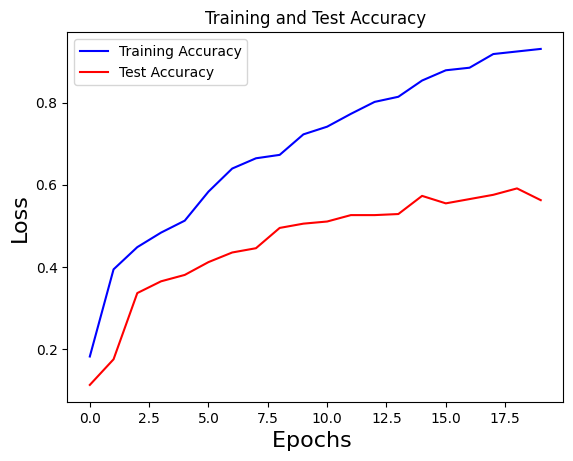

<Figure size 640x480 with 0 Axes>

In [26]:
# Plotting the train and validation accuracy curve
plt.plot(range(0,num_epochs), train_acc_per_epoch, 'b', label='Training Accuracy')
plt.plot(range(0,num_epochs), test_acc_per_epoch, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [27]:
# Storing model in pickel file
import pickle

# Specifying the path where you want to save the model
file_path = "./models/model.pkl"

# Saving the model's state dictionary to a pickle file
torch.save(model.state_dict(), file_path)

In [28]:
# Loadin the model from specific path
file_path = "./models/model.pkl"

model.load_state_dict(torch.load(file_path))


<All keys matched successfully>

### Evaluating the model using confusion matrix


In [29]:
def predict(model: nn.modules, inputs: torch.tensor) -> torch.tensor:
    """
    This function predicts the predicted outputs for the given test input sample

    Parameters
    ------------
        inputs : tensor, float32
        test input sample

    Returns:
    -------------
        predicted: tensor, float32
        Predicitons for each class by the model 
    """
    
    model = model.to(device)
    return model(inputs.to(device))

In [30]:
# Testing in test dataloader
dataiter = iter(test_loader)
data = next(dataiter)
features, labels = data

pred = predict(model=model, inputs=features.float())
pred = torch.argmax(pred, dim=-1)

acc_count = 0

for target, predict in zip(labels, pred):
    # print(f"Target: {target} | Predicted: {predict}")
    
    if target == predict:
        acc_count += 1

print(f"Total data: {len(labels)}")
print(f"Total corrected prediction: {acc_count}") 
print(f"Total accuracy: {acc_count/len(labels) * 100}%")

Total data: 32
Total corrected prediction: 13
Total accuracy: 40.625%


In [31]:
# Classes that are classified
classes: list= ["cat", "cow", "dog", "elephant", "goat", "leopard", "lion", "pig", "tiger", "zebra"]

In [32]:
from sklearn.metrics import confusion_matrix

labels = labels
pred = pred.cpu().numpy()

# Create confusion matrix
conf_matrix = confusion_matrix(labels, pred)

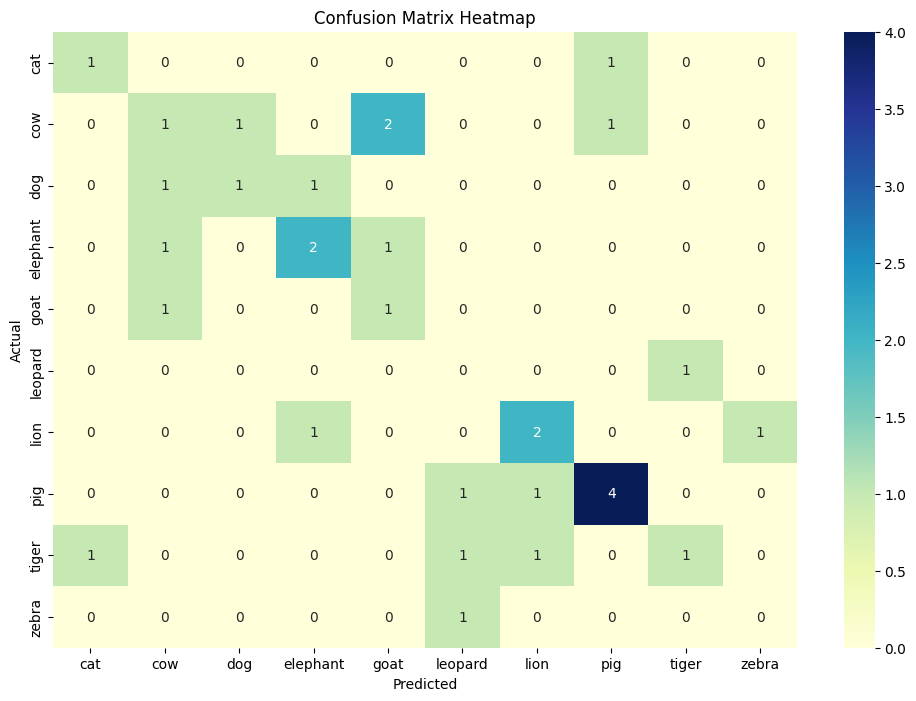

In [33]:
import seaborn as sns

# Creating a heatmap for confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d", xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

In [34]:
# Creating a classification report
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels, pred, target_names=[f'Class {label}' for label in classes])

# Print the classification report
print(report)

                precision    recall  f1-score   support

     Class cat       0.50      0.50      0.50         2
     Class cow       0.25      0.20      0.22         5
     Class dog       0.50      0.33      0.40         3
Class elephant       0.50      0.50      0.50         4
    Class goat       0.25      0.50      0.33         2
 Class leopard       0.00      0.00      0.00         1
    Class lion       0.50      0.50      0.50         4
     Class pig       0.67      0.67      0.67         6
   Class tiger       0.50      0.25      0.33         4
   Class zebra       0.00      0.00      0.00         1

      accuracy                           0.41        32
     macro avg       0.37      0.34      0.35        32
  weighted avg       0.45      0.41      0.42        32

